In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
%matplotlib inline
color = sns.color_palette()
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 200)
from sklearn.base import TransformerMixin
from scipy.stats import skew
import xgboost as xgb
from sklearn.cross_validation import KFold
import sklearn as sklearn
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import gc

C:\Users\justinxin\Anaconda3\envs\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# challenge 1

 You are in a meeting with a product owner, they just launched an additional customer care center of excellence(CoE), and have opportunity to cross-sell/upsell customers with additional products. They need your help in identifying which customersto pitch to and what product.At your disposal is historical data for the last 12 months of customer upgrades, their demographic and transaction data. The business has 4 products -video, data, home security and Voice. A customer might be subscribed to a single product, a combination of two or three products or have all 4 products. 

a). Describe how you would go about providing a solution to the business? 
What modeling approaches would you use? How would you measure the effectiveness of your solutions?

Answer: the fundamental question is who to target and what product, which can be split into two part. In the first part, we will look at how to effectively target potential cross_sell customers with better response rates, and the second part, what product to cross-sell for better conversion rates and higher business value.

For the first part, we can build a propensity model to estimate the likelihood/probability of response/conversion. This is a classification model and the performance can be measures in statistical terms like AUROC, Somer's D, f1 score, etc. 
For the second part. it's essentially a recommendation engine problem. Collaborative filting is a popular RE techinique that find candidate products for each user by either of the two following approaches. 
    1. User-centric approach: find the users who have demonstrated similar taste to user A: find the products that these users are most interested in based on their history; and finally use those users' preferences to make the prediction for the user A
    2. product-centric approach: estimate the similarity of all products against each other; based on user A's existing product selection, estimate his/her interest in other products based on how similar those products ar to the existing selection portfolio of user A
Ther performance of this model is measured based on conversion rates and the business values. 

Due to time and bandwidth limitations, in part b) of the challenge, we will focus on building a propensity model to measure the likelihood of response. 

Note:  Having gone through the data, I realize that the existing customer product preferences are highly imbalanced, for example, customers that own 'Home' product is only around 8000/300000 = 2.6%. The collaborative filting techniques may not work well for these kinds of data imbalance scenarios. An alternative approach is to predict the propensity of a customer choosing a specific product irrespective of other products(meaning building a seperate classification model for each product), based on the rank ordering of these product preferences as well as the existing product ownership for a specific customer, we can choose what product to cross-sell.  Due to time limitation, I will not explore this option



b). Now assume, the business partner has prepared a pipe delimited dataset for you. The dataset contains 128 variables and 300,000 records. The dataset contains records of customer that were serviced by the CoE in the last 9 months, and the analyst created a binary indicator (1 = YES, 0 = NO) of which customers were cross-sold as the target variable.The remaining independent attributes are based on the snapshot view of the customer’s data as ofthe time of serviceat the CoE. What modeling approaches would you use? What would your output to the business look like? How would you measure the effectiveness of your solutions?Based on your analysis, what recommendations and or insights do you have for the business?

Answer: The target is a binary cross_sold variable.  We will use classification methods. Some popular ones are logistic regression, classficiation trees, etc. Refer to the following for detailed analysis

In [2]:
### read files 
comcast=pd.read_csv('ds_tech.txt.txt',sep='|')
print('the shape of the files is {}'.format(comcast.shape))

the shape of the files is (300000, 128)


In [3]:
## quickly check the data distribution characteriscs. Most of the variables are numeric vairables. It appears that there are missingness, some missing rates are very high as well 
comcast.describe()

,target,dvr_playback,dvr_program,dvr_view,linear_chan,linear_program,linear_view,viewing,vod_playback,vod_program,vod_view,bs_tech_service_working,never_pay_flag,svcr_issue_resolved,t2_channel,t2_dvr_playback,t2_dvr_program,t2_dvr_view,t2_linear_chan,t2_linear_program,t2_linear_view,t2_program,t2_viewing,t2_vod_playback,t2_vod_programs,t2_vod_view,echan_full_court,echan_game_plan,mls_direct_kick,nleague_plan,nhl_center_ice,resi_tech_overall_sat,resi_tech_rep_sat,rgu_bulk_voice,svcr_overall_sat,svcr_rep_sat,svod_bollywood_hits,svod_dchan_family_movies,use_self_service_all,video_addon_family_tier,video_addon_music_choice,home_cam_id,home_cam_od,home_dw_takeo,home_oth_sens_co,home_oth_sens_cur,home_oth_sens_fld,home_oth_sens_gls,home_peri_wifi,home_sik,home_system_upgrades,data_penetration_pct,prev_number_of_products,prev_rgu_voice,bllng_amt,voice_total_min,fcomp_internet,bulk_ind,total_vod_free_lease,video_penetration_pct,hic_macs_count,x1_platform,cloud_dvr,video_days_on_books,data_total_gb,offer_months_duration,mrm_rec_data_amt,delinquent_90_balance_amt,prev_rgu_video,ucomp,prev_rgu_data,email_flag,ftcomp_internet,IVR_RESOLVED_T1,IVR_RESOLVED_ALL,IVR_T4,IVR_RESOLVED_T2,SPIX,vin_ind,infin_ind,tellop_ind,DVD_LOVERS,DOG_LOVERS,AGE0,AGE0_4,AGE1,AGE10,AGE10_14,AGE11,AGE12,AGE13,AGE14,AGE15,AGE15_19,AGE16,AGE17,AGE18,AGE18UP,AGE19,AGE2,AGE20,AGE20_24,AGE21,AGE21UP,AGE25_29,AGE3,AGE30_34,AGE35_39,AGE4,AGE40_44,AGE45_49,AGE5,AGE5_9,AGE50_54,AGE55_59,AGE6,AGE60_64,AGE65_69,AGE7,AGE70_74,AGE75_79,AGE8,AGE80_84,AGE85UP,AGE9,PREMIUM
count,300000.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,98.000000,0.0,367.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,1851.000000,1851.000000,300000.000000,367.000000,367.000000,300000.0,300000.000000,300000.000000,300000.000000,300000.00000,300000.000000,300000.000000,300000.0,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.0,299975.000000,293048.000000,293048.000000,290275.000000,106779.000000,296572.000000,300000.000000,138212.000000,299975.000000,252230.00000,300000.000000,300000.000000,242163.000000,250624.000000,181554.000000,290275.000000,300000.000000,293048.000000,296572.000000,293048.000000,49680.0,296572.000000,85714.000000,85714.000000,85714.000000,85714.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,293048.000000,298627.000000,298627.000000,298627.000000,298627.000000,298627.000000,298627.000000,298627.000000,298627.000000,298627.000000,298627.000000,298627.000000,298627.000000,298627.000000,298627.000000,298684.000000,298627.000000,298627.000000,298627.000000,298627.000000,298627.000000,298627.000000,298627.000000,298627.000000,298627.000000,298627.000000,298627.000000,298627.000000,298627.000000,298627.000000,298627.000000,298627.000000,298627.000000,298627.000000,298627.000000,298627.000000,298627.000000,298627.000000,298627.000000,298627.000000,298627.000000,298627.000000,298627.000000,300000.000000
mean,0.023347,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.846939,NaN,0.920981,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000010,0.000017,0.000040,0.000427,0.000417,4.673690,4.846029,0.000117,4.482289,4.528610,0.0,0.003193,0.000543,0.000357,0.00976,0.000023,0.000030,0.0,0.000003,0.000050,0.000270,0.000720,0.000397,0.000160,0.0,46.169411,2.106457,0.423405,131.101230,459.925439,0.126232,0.078007,27.460590,43.409176,1.62468,0.297107,0.175247,2747.939764,148.236582,16.757367,41.907584,0.022755,0.808622,0.357616,0.846387,0.0,0.033206,0.001948,0.953823,1.153756,0.014467,0.325717,0.234020,3.594213,7.509600,6.188617,0.846387,0.012664,0.064114,0.012697,0.012983,0.064497,0.012846,0.012769,0.012857,0.013059,0.013285,0.066976,0.013462,0.013726,0.013494,697.695166,0.013026,0.012988,0.013359,0.068399,0.013221,0.727341,0.073055,0.012970,0.067653,0.066943,0.012811,0.068849,0.073564,0.012760,0.063739,0.072213,0.064161,0.012778,0.055887,0.041227,0.012636,0.

## 1. Data exploration

In [4]:
#### Find the list of characteristic columns
comcast.rename(columns={'product':'existing_product'},inplace=True)
character_columns=comcast.select_dtypes(include=['object']).columns.values
character_columns

array(['existing_product', 'MAJOR_CREDIT_CARD_LIF'], dtype=object)

In [5]:
## find low cardinality numerical columns

nums_cat_columns=[x for x in comcast.columns if comcast[x].nunique()<=5 and x not in character_columns]
nums_cat_columns.remove('target')


In [6]:
def plot_categorical(data, col, size=[8 ,4], xlabel_angle=0, title=''):
    '''use this for ploting the count of categorical features'''
    plotdata = data[col].value_counts()
    plt.figure(figsize = size)
    sns.barplot(x = plotdata.index, y=plotdata.values)
    plt.title(title)
    if xlabel_angle!=0: 
        plt.xticks(rotation=xlabel_angle)
    plt.show()


def plot_distribution_comp(var,nrow=2):
    
    i = 0
    t1 = comcast.loc[comcast['target'] != 0]
    t0 = comcast.loc[comcast['target'] == 0]

    sns.set_style('whitegrid')
    plt.figure()
    fig, ax = plt.subplots(nrow,2,figsize=(12,6*nrow))

    for feature in var:
        i += 1
        plt.subplot(nrow,2,i)
        sns.kdeplot(t1[feature], bw=0.5,label="TARGET = 1")
        sns.kdeplot(t0[feature], bw=0.5,label="TARGET = 0")
        plt.ylabel('Density plot', fontsize=12)
        plt.xlabel(feature, fontsize=12)
        locs, labels = plt.xticks()
        plt.tick_params(axis='both', which='major', labelsize=12)
    plt.show();
    
# Plot distribution of one feature
def plot_distribution(feature,color):
    plt.figure(figsize=(10,6))
    plt.title("Distribution of %s" % feature)
    sns.distplot(comcast[feature].dropna(),color=color, kde=True,bins=100)
    plt.show()  
    
def plot_stats(feature,label_rotation=False,horizontal_layout=True):
    temp = comcast[feature].value_counts()
    df1 = pd.DataFrame({feature: temp.index,'Number of contracts': temp.values})

    # Calculate the percentage of target=1 per category value
    cat_perc = comcast[[feature, 'target']].groupby([feature],as_index=False).mean()
    cat_perc.sort_values(by='target', ascending=False, inplace=True)
    
    if(horizontal_layout):
        fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12,6))
    else:
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(12,14))
    sns.set_color_codes("pastel")
    s = sns.barplot(ax=ax1, x = feature, y="Number of contracts",data=df1)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    
    s = sns.barplot(ax=ax2, x = feature, y='target', order=cat_perc[feature], data=cat_perc)
    if(label_rotation):
        s.set_xticklabels(s.get_xticklabels(),rotation=90)
    plt.ylabel('Percent of target with value 1 [%]', fontsize=10)
    plt.tick_params(axis='both', which='major', labelsize=10)

    plt.show();


Below plots the distribution plots as well as cross-sold rate by each category

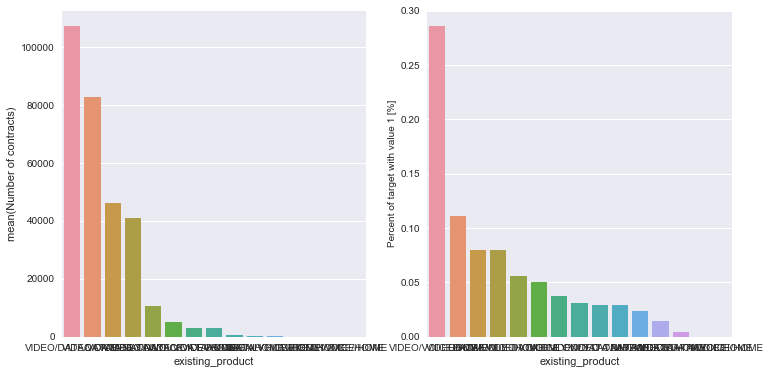

In [7]:
plot_stats('existing_product')

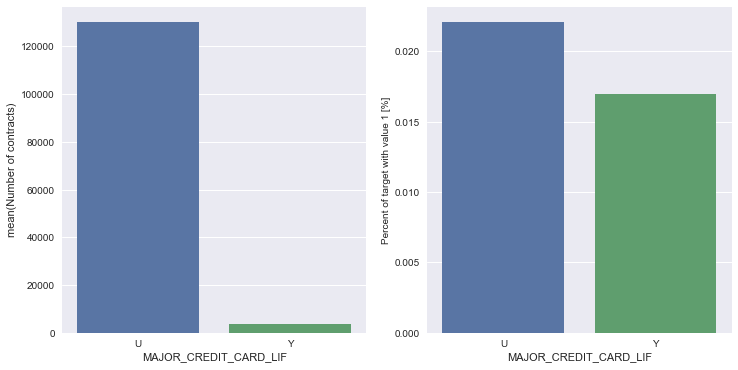

In [8]:
plot_stats('MAJOR_CREDIT_CARD_LIF')

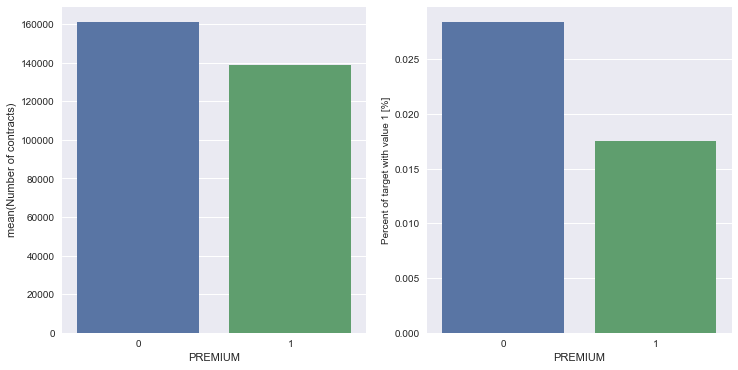

In [9]:
plot_stats('PREMIUM')

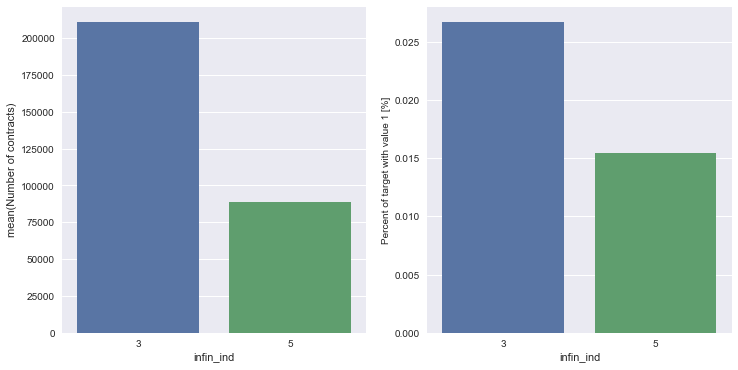

In [10]:
plot_stats('infin_ind')

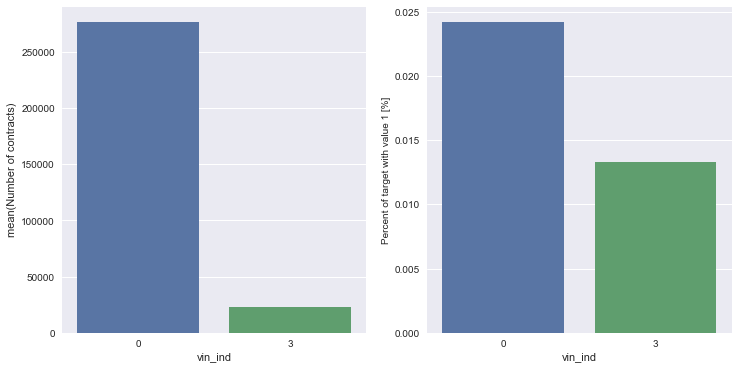

In [11]:
plot_stats('vin_ind')

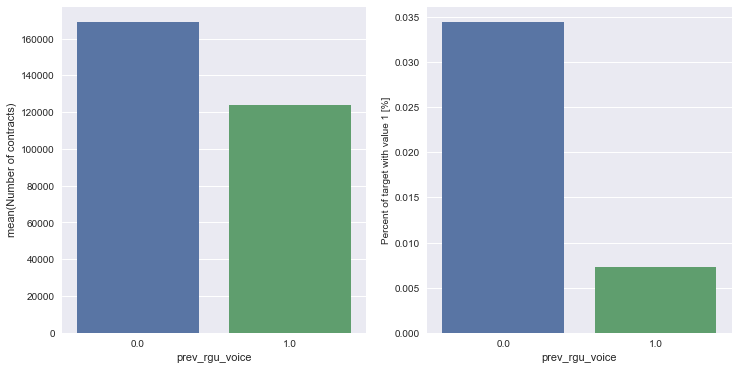

In [12]:
plot_stats('prev_rgu_voice')

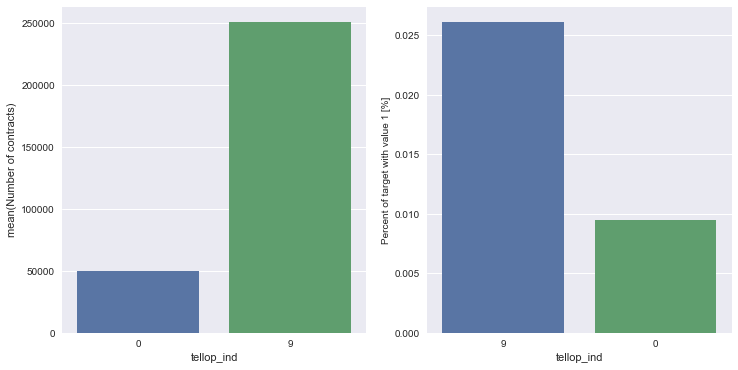

In [13]:
plot_stats('tellop_ind')

It would appear that most of the categorical variables have somewhat sloping power on the target variables.  Some of these variables are also highly skewed 

Below, we examine the distribution of numeric variables by different values of the target(0/1). A majority of these variables share the same distribution for 0/1 target values, suggesting that they probablly only have very marginal sloping power; while the distributions for some other variables at 0/1 target values are different, suggesting that they may have certain sloping power on the target variable.  An example is 'data_total_gb', which measures the total data upload/download from the web, Taret=1 population is highly concentrated around low data usage areas, which suggests that these users are more likely cross-sold with high speed internet data product. 

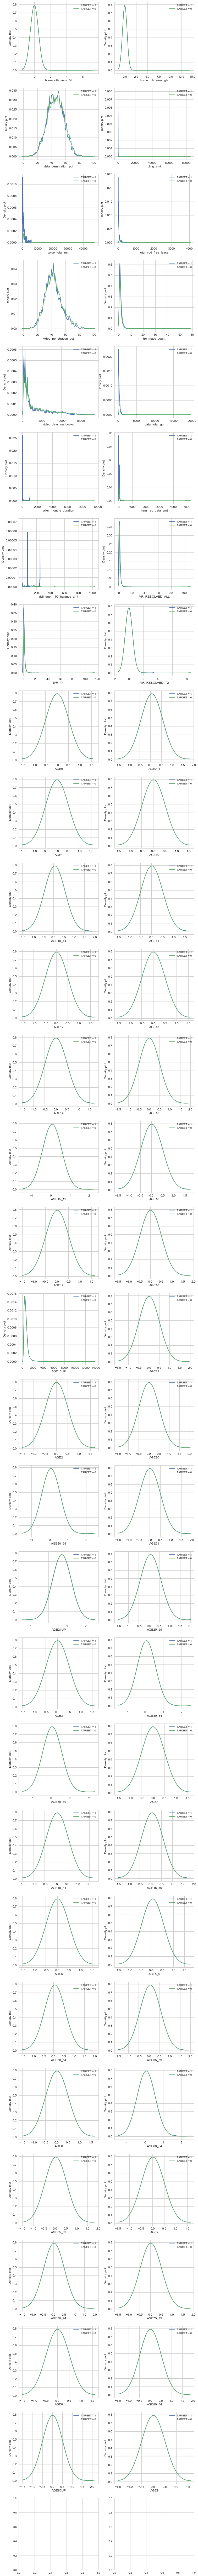

In [14]:

var = [x for x in comcast.columns if x not in character_columns and x not in nums_cat_columns and x not in ['target']]

plot_distribution_comp(var,nrow=30)

## 2.  Data Preprocessing

### First remove low variance (standard deviation = 0) features

In [15]:
low_variance=[x for x in nums_cat_columns  if comcast[x].std()==0]  
comcast.drop(columns=low_variance,inplace=True)

In [16]:
low_variance

['svod_bollywood_hits', 'home_dw_takeo', 'home_system_upgrades', 'email_flag']

In [17]:
comcast.shape

(300000, 124)

### Dropping high missing rate variables (missing rate > 80%)

In [18]:
def find_missing(data):
    # number of missing values
    count_missing = data.isnull().sum().values
    # total records
    total = data.shape[0]
    # percentage of missing
    ratio_missing = count_missing/total
    # return a dataframe to show: feature name, # of missing and % of missing
    return pd.DataFrame(data={'missing_count':count_missing, 'missing_ratio':ratio_missing}, index=data.columns.values)
miss_feat_df=find_missing(comcast)
missing_features = miss_feat_df[miss_feat_df.missing_ratio > 0.80].index
comcast.drop(missing_features, axis=1, inplace=True)
comcast.shape

(300000, 95)

a total of 39 variables with high missing rates are dropped, which are shown below

In [19]:
missing_features

Index(['dvr_playback', 'dvr_program', 'dvr_view', 'linear_chan',
       'linear_program', 'linear_view', 'viewing', 'vod_playback',
       'vod_program', 'vod_view', 'bs_tech_service_working', 'never_pay_flag',
       'svcr_issue_resolved', 't2_channel', 't2_dvr_playback',
       't2_dvr_program', 't2_dvr_view', 't2_linear_chan', 't2_linear_program',
       't2_linear_view', 't2_program', 't2_viewing', 't2_vod_playback',
       't2_vod_programs', 't2_vod_view', 'resi_tech_overall_sat',
       'resi_tech_rep_sat', 'svcr_overall_sat', 'svcr_rep_sat'],
      dtype='object')

### Missing inputation

impute categorical columns with the mode, and other numerical columns with the column mean

In [20]:
class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.
        Columns of categorical columns are imputed with the most frequent value 
        in column.
        Other columns are imputed with mean of column.
        """
    def fit(self, X, y=None):
        self.fill = pd.Series([X[c].value_counts().index[0]
            if c in character_columns or c in nums_cat_columns else X[c].mean() for c in X],
            index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.fill)

comcast = DataFrameImputer().fit_transform(comcast)

### One hot encoding for categorical columns

In [21]:
categorical_columns=list(character_columns)+nums_cat_columns
dummy_columns=[x for x in categorical_columns if x in comcast.columns]

comcast=pd.get_dummies(comcast,columns=dummy_columns)



## 3. Prepare the build and validation samples

60/40 split on the build/validation sample. Model performance will be based on the validation sample. Decided not to try cross validation because of the excessive programming running time. 

In [22]:

###comcast[features] = comcast[features].apply(lambda x: pd.to_numeric(x,errors='ignore'))
excluded_feats = ['target']
features = [f_ for f_ in comcast.columns if f_ not in excluded_feats]

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(comcast[features], comcast['target'], test_size=0.4, random_state=0)

In [23]:
pd.set_option('display.max_rows', 500)
comcast.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
target,300000.0,0.023347,0.151002,0.0000,0.000000,0.000000,0.000000,1.0000
home_oth_sens_fld,300000.0,0.000270,0.025754,0.0000,0.000000,0.000000,0.000000,6.0000
home_oth_sens_gls,300000.0,0.000720,0.057557,0.0000,0.000000,0.000000,0.000000,13.0000
data_penetration_pct,300000.0,46.169411,12.111097,0.0000,37.587500,46.270000,54.590000,100.0000
bllng_amt,300000.0,131.101230,287.897913,-101.4500,77.990000,128.600000,172.250000,84831.3000
voice_total_min,300000.0,459.925439,462.537545,0.0000,459.925439,459.925439,459.925439,47444.0000
total_vod_free_lease,300000.0,27.460590,29.909835,0.0000,15.000000,27.460590,27.460590,4055.0000
video_penetration_pct,300000.0,43.409176,12.216040,0.0000,35.100000,42.480000,50.670000,100.0000
hic_macs_count,300000.0,1.624680,0.890370,1.0000,1.000000,1.000000,2.000000,57.0000
video_days_on_books,300000.0,2747.939764,3021.214446,-6.0000,569.000000,1931.500000,2881.000000,18618.0000


# 4. Model building

In the following, we will try to use extratree classifier and random forest classifier to build two toy models. With time limitations, 
I have decided not to do additional feature engineering, or grid search for the hyperparameters

In [24]:
SEED=12345
ntrain = x_train.shape[0]
ntest = x_test.shape[0]

#x_train = x_train[features]
#x_test = x_test[features]

#kf = KFold(n_splits = NFOLDS, shuffle=True, random_state=SEED)

class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None):
        params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict_proba(x)[:,1]

et_params = {
    'n_jobs': 16,
    'n_estimators': 200,
    'max_features': 0.5,
    'max_depth': 12,
    'min_samples_leaf': 2,
}

rf_params = {
    'n_jobs': 16,
    'n_estimators': 200,
    'max_features': 0.2,
    'max_depth': 12,
    'min_samples_leaf': 2,
}


#xg = XgbWrapper(seed=SEED, params=xgb_params)
et = SklearnWrapper(clf=ExtraTreesClassifier, seed=SEED, params=et_params)
rf = SklearnWrapper(clf=RandomForestClassifier, seed=SEED, params=rf_params)

et.train(x_train,y_train)
rf.train(x_train,y_train)

In [25]:
feat_importance_et=pd.DataFrame(list(zip(x_train.columns.values,et.clf.feature_importances_)),columns=['feature','importance'])
feat_importance_et.sort_values(by=['importance'],ascending=False,inplace=True)


In [26]:
feat_importance_et

,feature,importance
66,existing_product_VIDEO/DATA/VOICE,0.066072
9,data_total_gb,0.034502
144,tellop_ind_0,0.032044
3,bllng_amt,0.029694
145,tellop_ind_9,0.027873
113,prev_number_of_products_1.0,0.023134
118,prev_rgu_voice_1.0,0.022851
7,hic_macs_count,0.022789
63,existing_product_VIDEO ONLY,0.021792
117,prev_rgu_voice_0.0,0.018910


In [27]:
feat_importance_cf=pd.DataFrame(list(zip(x_train.columns.values,rf.clf.feature_importances_)),columns=['feature','importance'])
feat_importance_cf.sort_values(by=['importance'],ascending=False)

,feature,importance
3,bllng_amt,0.040819
9,data_total_gb,0.038557
11,mrm_rec_data_amt,0.026899
8,video_days_on_books,0.021303
30,AGE18UP,0.020958
6,video_penetration_pct,0.019914
66,existing_product_VIDEO/DATA/VOICE,0.019318
2,data_penetration_pct,0.019149
46,AGE50_54,0.017526
5,total_vod_free_lease,0.016309


the feature importance ranking of these two models are quite different. This is quite common for these tree based 
methods, which is driven by the fact that at each node split, a subset of random features are drawn. In extremely randomized trees (ExtraTreesClassifier), randomness goes one step further in the way splits are computed. As in random forests, a random subset of candidate features is used, but instead of looking for the most discriminative thresholds, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias

For simplicity, We will use the top 30 features from the random forest model to build a refined classifier model

In [28]:
subset_features = list(feat_importance_cf.head(30).feature.values)


In [29]:
x_train=x_train[subset_features]
rf_new = SklearnWrapper(clf=RandomForestClassifier, seed=SEED, params=rf_params)
rf_new.train(x_train,y_train)
x_test=x_test[subset_features]
rf_new.predict(x_test)

array([0.0025669 , 0.02398804, 0.01760496, ..., 0.00930412, 0.01865224,
       0.00393124])

## 4 Model performance assessment

we will use Somer's D and ROC Curve to measure the model performance. Somer's D is a measure of model rank
ordering power, Somer's D = 2 * AUROC-1.  Somer'D is in the range of 0-1 and the larger the value, the better the model performance

In [30]:
from sklearn.metrics.ranking import roc_auc_score, roc_curve
def somers_d(y_true, y_score, average="macro",sample_weight=None):
    return 2*roc_auc_score(y_true,y_score,average,sample_weight)-1


In [31]:
somers_d(y_test,rf_new.predict(x_test))

0.49798253438590545

In [32]:
fpr,tpr, td= roc_curve(y_test,rf_new.predict(x_test))

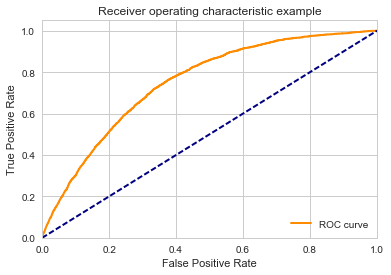

In [33]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve' )
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic example')
plt.legend(loc="lower right")
plt.show()

The POC model Somer's D is 0.5 in the test sample. Unfortunately, I don't have time to explore/refine other candidate models, and select the best out of all.  

There is no immediate business
insights that can be drawn, as the meta data info is very obscure. Directionally, The top variables in the model make sense; for example, 
bllng_amt (billing total,  data_total_gb (total data usage), measure the account usage/activity information, which is a proxy of the product penetration

# Challenge 2

If you randomly type a 6 digit number on a note, what is the probability that you can see the same number if you flipyour noteupside down? How would you explain your answer to a 6 year old?

Answer: Of the 10 numbers (0,1,2,3,4,5,6,7,8,9). 0,1,8 can make it such that we can see the same number if we flip the note upside down when they are in mirror positions; while 6/9 have to come in pairs in mirror positions. 
Example: 1 0 6 9 0 1,  8 1 0 0 1 8, 9 8 1 1 8 6

There are a total of 9 X 10^5 unique number of 6 digit numbers
there are 4 ( position 1/6, first number can be 1,6,9,8)
X 5 ( position 2/5, can be 0,1,6,9,8 ) X 5 ( position 3/4 can be 0,1,6,9,8) = 100 difference scenarios

and the probability is 100/(9 * 10^5), around 0.0001


